# Import libraries

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('cleaned_set.csv')



### trip duration to hours

In [31]:
train['trip_dur_in_hr']=train['trip_duration']/3600
train['trip_dur_in_hr'].describe()


count    1.458487e+06
mean     2.646940e-01
std      8.809655e-01
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      2.399778e+01
Name: trip_dur_in_hr, dtype: float64

max value in 23 hour, we gonna remove trip with duration more than 2h

In [32]:
train=train[train['trip_dur_in_hr'] <= 2]

In [36]:
def create_datetime(df):

    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

    # Hour of the day
    df['pickup_seconds'] = (df['pickup_sec'] + df['pickup_min'] * 60 + df['pickup_hour'] * 3600)
    #df['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in df['pickup_mon']]
    #df['quarter']=df['pickup_datetime'].dt.quarter  ## quarter of the year
    df['mid_latitude']=(df['dropoff_latitude']-df['pickup_latitude'])/2
    df['mid_longitude']=(df['dropoff_longitude']-df['pickup_longitude'])/2
    #df['night']=[1 if (i==0 or i>=20)  else 0 for i in df['pickup_hour']]
    #df['too_late']=[1 if (i<5 and i>0)  else 0 for i in df['pickup_hour']]
    

# Harvesine Distance
def create_speed(df):
    #calcul de la vitesse moyenne pour une course
    df['speed1'] = df['distance1']/df['trip_duration']
def create_distance(df):
    
    #Haversine distance already in the file
    #df['havers_dist'] = df.apply(lambda x: haversine(
        #(x['pickup_latitude'], x['pickup_longitude']),
        #(x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

def bearing_heading(lat1, lon1, lat2, lon2):
    #R = 6371  # in km
    delta = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    
    X = np.cos(lat2) * np.sin(delta)
    Y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta)
    beta = np.arctan2(X, Y)
    
    return np.degrees(beta)

def create_meanspeedhour_list(df):
    #création d'une liste des meanspeedhour associées à chaque heure et jour
    for j in range (0,7):
        heure0 = round(df['speed1'][(df['pickup_hour'] == 0) & (df['pickup_day'] == j)].mean(),6)
        MSH_list.append([heure0])
        for i in range(1,24):
            MSH_list[j].append(round(df['speed1'][(df['pickup_hour'] == i) & (df['pickup_day'] == j)].mean(),6))
        
    print(MSH_list)
        
def create_meanspeedhour(df):
    df['average_speed']=df['pickup_hour']
    for i in range(0,24):
        for j in range (0,7):
            df['average_speed'][(df['pickup_hour'] == i) & (df['pickup_day'] == j)] = MSH_list[j][i]
            
def create_average_duration(df):
    df['average_duration']=df['distance1']/df['average_speed']

create_datetime(train)
create_speed(train)
create_distance(train)
MSH_list=[];
create_meanspeedhour_list(train)
create_meanspeedhour(train)
create_average_duration(train)

[[0.005002, 0.004943, 0.004843, 0.004999, 0.005855, 0.005757, 0.004578, 0.003485, 0.002834, 0.002739, 0.002804, 0.002842, 0.002812, 0.002924, 0.00287, 0.002844, 0.002925, 0.002889, 0.002942, 0.003343, 0.003752, 0.003851, 0.003957, 0.004359], [0.004595, 0.004814, 0.004842, 0.005062, 0.005689, 0.005544, 0.004322, 0.003214, 0.002531, 0.00241, 0.00241, 0.002399, 0.002438, 0.002507, 0.002524, 0.002496, 0.002638, 0.002603, 0.00266, 0.003064, 0.003437, 0.003576, 0.00371, 0.004054], [0.004298, 0.004589, 0.004701, 0.004937, 0.005563, 0.005521, 0.004406, 0.003219, 0.002573, 0.00242, 0.002424, 0.002365, 0.002348, 0.002429, 0.00242, 0.002412, 0.002567, 0.002508, 0.002567, 0.00288, 0.003326, 0.003476, 0.003546, 0.003847], [0.004169, 0.004525, 0.004638, 0.004992, 0.005513, 0.005551, 0.004414, 0.003224, 0.002537, 0.002445, 0.002444, 0.002408, 0.002398, 0.002505, 0.002455, 0.00242, 0.002563, 0.002538, 0.00257, 0.002842, 0.003198, 0.003311, 0.003358, 0.003628], [0.003853, 0.004135, 0.004251, 0.004547, 

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\EL MAHDI\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
train['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(train['pickup_latitude'], 
                                                                       train['pickup_longitude'],
                                                                       train['dropoff_latitude'], 
                                                                       train['dropoff_longitude'])]

In [38]:
train.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr', 'average_speed', 'pickup_seconds',
       'mid_latitude', 'mid_longitude', 'Manhattan_dist', 'Chebyshev_dist',
       'average_duration', 'bearing_direction', 'speed1'],
      dtype='object')

In [39]:
train = train.drop(['Unnamed: 0'], axis=1)

In [40]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr', 'average_speed', 'pickup_seconds',
       'mid_latitude', 'mid_longitude', 'Manhattan_dist', 'Chebyshev_dist',
       'average_duration', 'bearing_direction', 'speed1'],
      dtype='object')

In [41]:
## drop columns to avoid data type problems in xgboost
train=train.drop(['id','pickup_datetime','dropoff_datetime','store_and_fwd_flag', 'logduration','trip_dur_in_hr','pickup_DayHour', 'speed',
                 'speed1'],1)

In [47]:
train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_hour',
       'x1', 'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'average_speed', 'pickup_seconds', 'mid_latitude', 'mid_longitude',
       'Manhattan_dist', 'Chebyshev_dist', 'average_duration',
       'bearing_direction'],
      dtype='object')

In [48]:
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,x1,y1,...,pickup_date,pickup_mon,average_speed,pickup_seconds,mid_latitude,mid_longitude,Manhattan_dist,Chebyshev_dist,average_duration,bearing_direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,17,1331.434577,-4637.812000,...,14,3,0.002889,62695,-0.001167,0.008762,5969.246577,5970.467339,514.214895,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,1332.163782,-4639.820928,...,12,6,0.003415,2615,-0.003706,-0.009533,5971.548951,5971.984710,496.065207,-117.153768
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1331.767887,-4638.018298,...,19,1,0.002399,41724,-0.026926,-0.013153,5969.786185,5973.100801,1872.671004,-159.680165
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,19,1330.136170,-4641.805883,...,6,4,0.002880,70351,-0.006626,-0.001114,5971.942053,5973.002028,340.052128,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,13,1331.664551,-4635.836280,...,26,3,0.002963,48655,-0.005344,0.000065,5967.500832,5968.468922,262.066019,179.473585


In [49]:
train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_hour',
       'x1', 'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'average_speed', 'pickup_seconds', 'mid_latitude', 'mid_longitude',
       'Manhattan_dist', 'Chebyshev_dist', 'average_duration',
       'bearing_direction'],
      dtype='object')

In [50]:
y=np.log(train['trip_duration'].values + 1)
x=train.drop(['trip_duration'],1)

In [51]:
from sklearn.cross_validation import train_test_split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.2, random_state=1996)

In [52]:
dtrain = xgb.DMatrix(Xtrain, label=ytrain)

In [55]:
dvalid = xgb.DMatrix(Xvalid, label=yvalid)
#dtest = xgb.DMatrix(test[feature_names].values)
evallist = [(dtrain, 'train'), (dvalid, 'valid')]

num_round = 100000

xgb_pars = {'min_child_weight': 10, 'eta': 0.03, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [56]:
model = xgb.train(xgb_pars, dtrain, num_round, evallist, early_stopping_rounds=90, maximize=False, verbose_eval=100)


[0]	train-rmse:5.83152	valid-rmse:5.83023
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 90 rounds.
[100]	train-rmse:0.448847	valid-rmse:0.454329
[200]	train-rmse:0.326393	valid-rmse:0.342733
[300]	train-rmse:0.312905	valid-rmse:0.336845
[400]	train-rmse:0.302794	valid-rmse:0.333626
[500]	train-rmse:0.296244	valid-rmse:0.331716
[600]	train-rmse:0.291997	valid-rmse:0.330517
[700]	train-rmse:0.28799	valid-rmse:0.329496
[800]	train-rmse:0.28494	valid-rmse:0.328813
[900]	train-rmse:0.282371	valid-rmse:0.328238
[1000]	train-rmse:0.279909	valid-rmse:0.327799
[1100]	train-rmse:0.277257	valid-rmse:0.327235
[1200]	train-rmse:0.274784	valid-rmse:0.326716
[1300]	train-rmse:0.27257	valid-rmse:0.32634
[1400]	train-rmse:0.27051	valid-rmse:0.325997
[1500]	train-rmse:0.268515	valid-rmse:0.325621
[1600]	train-rmse:0.26682	valid-rmse:0.325432
[1700]	train-rmse:0.264995	valid-rmse:0.325157
[1800]	train-rmse:0.26336	val

In [57]:
print('=====> Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.31928


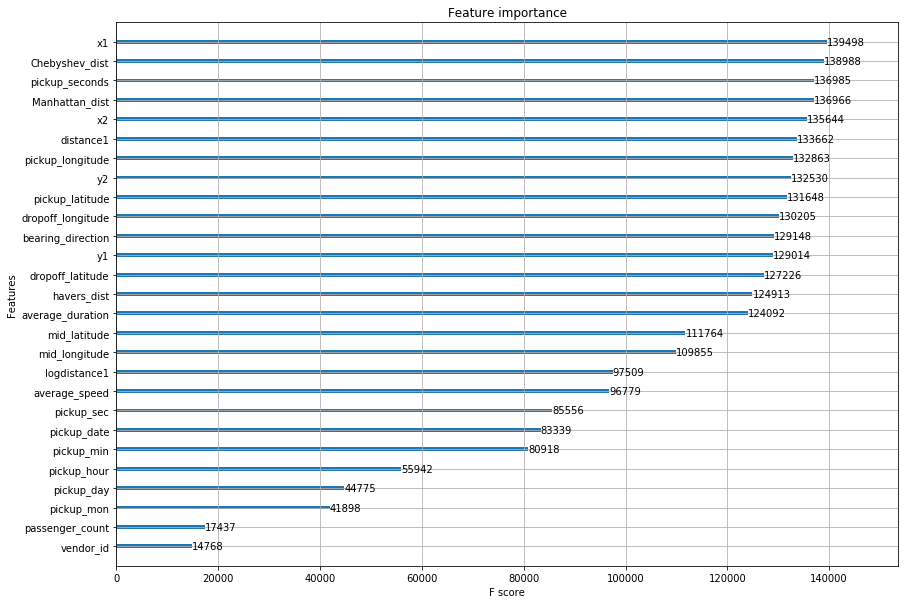

In [58]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20,11))
xgb.plot_importance(model, ax=ax1, height=0.2, xlim=None,
                    ylim=None, title='Feature importance',
                    xlabel='F score', ylabel='Features',
                    importance_type='weight', max_num_features=None,
                    grid=True)
plt.show()

In [59]:
import pickle
pickle.dump(model,open('xgb_pred2.sav','wb'))

# TEST

In [60]:
test_dataset = pd.read_csv('test.csv')

In [61]:
#Latitude and Longitude to cartesian cordindates converesion
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    x = R * np.cos(lat) * np.cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    y = R * np.cos(lat) * np.sin(lon)
    return y
# extracting cartesian x,y cordinates form latitude and longitude
test_dataset['x1']=[cartesian_x(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['y1']=[cartesian_y(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['x2']=[cartesian_x(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]
test_dataset['y2']=[cartesian_y(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]

In [62]:
def euclidean_distance(a1,b1,a2,b2):
    dist=np.sqrt((a2-a1)**2+(b2-b1)**2)
    return dist
    
test_dataset['distance1']=[euclidean_distance(i,j,k,l) for i,j,k,l in zip(test_dataset['x1'], 
                                                                          test_dataset['y1'],
                                                                          test_dataset['x2'], 
                                                                          test_dataset['y2'])]

test_dataset['logdistance1']=np.log(test_dataset['distance1']+1)

In [65]:
from haversine import haversine
def create_distance1(df):
    
    #Haversine distance already in the file
    df['havers_dist'] = df.apply(lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

def create_datetime_weekmont(df):
    
    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_min'] = df['pickup_datetime'].dt.minute
    df['pickup_sec'] = df['pickup_datetime'].dt.second
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_date'] = df['pickup_datetime'].dt.day
    df['pickup_mon'] = df['pickup_datetime'].dt.month

In [66]:
create_distance1(test_dataset)
create_datetime_weekmont(test_dataset)
create_datetime(test_dataset)

test_dataset['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(test_dataset['pickup_latitude'], 
                                                                       test_dataset['pickup_longitude'],
                                                                       test_dataset['dropoff_latitude'], 
                                                                       test_dataset['dropoff_longitude'])]



In [68]:

create_meanspeedhour(test_dataset)
create_average_duration(test_dataset)

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\EL MAHDI\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
test_dataset.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds',
       'mid_latitude', 'mid_longitude', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')

In [70]:
Xtrain.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
       'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
       'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'average_speed', 'pickup_seconds', 'mid_latitude', 'mid_longitude',
       'Manhattan_dist', 'Chebyshev_dist', 'average_duration',
       'bearing_direction'],
      dtype='object')

In [72]:
test=test_dataset.drop(['id','pickup_datetime','store_and_fwd_flag'], axis=1)

In [75]:
test.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds',
       'mid_latitude', 'mid_longitude', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')

In [76]:
model=pickle.load(open('xgb_pred2.sav','rb'))

In [77]:
dtest = xgb.DMatrix(test[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
       'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
       'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'average_speed', 'pickup_seconds', 'mid_latitude', 'mid_longitude',
       'Manhattan_dist', 'Chebyshev_dist', 'average_duration',
       'bearing_direction']])

ytest = model.predict(dtest)

In [78]:
np.exp(np.round(ytest[1:10]))-1

array([ 402.4288,  402.4288, 1095.6332,  402.4288, 1095.6332, 1095.6332,
       1095.6332, 2979.958 ,  402.4288], dtype=float32)

In [79]:
test['trip_duration'] = np.round(np.exp(ytest)) - 1

In [80]:
test_dataset['trip_duration']=np.round(np.exp(ytest)) - 1

In [81]:
test_dataset[['id', 'trip_duration']].to_csv('submission_finale.csv', index=False)